In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm, tqdm_notebook

# This notebook seeks to use all OPV processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This second NN will incorporate morphological information. However, morphological descriptors will be averaged per sample, similar to how device metrics are an average of performance across the active layer

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. This will similarly only include good devices

- DataFrame containing device-averaged morphology descriptors

### Outputs:
- Tensor of predicted performance for given processing conditions

In [3]:
#Take in data as a dataframe for easy preprocessing
total_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_total_df.xlsx')
print (total_df.shape)
total_df.head()

(108, 20)


,Unnamed: 0,Anneal_time,Anneal_temp,Substrate,Device,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Ecc_avg,Ecc_stdev,Orient_avg,Orient_stdev,Perim_avg,Perim_stdev,GMM_label,PCE,VocL,Jsc,FF
0,0,15,100,4,2,17.194652,29.172066,8.554721,14.246681,0.820518,0.142370,-0.050137,1.067225,97.003245,352.677591,1,2.311387,0.577792,6.963861,57.44484
1,1,15,100,4,4,13.709728,14.635628,6.938374,7.985216,0.824877,0.138410,-0.205623,1.075388,48.559552,98.492589,1,1.763230,0.522596,7.047848,47.87256
2,2,15,100,4,7,18.211098,21.013541,8.857453,10.356933,0.826205,0.148190,-0.414390,1.047842,75.736366,151.456627,1,2.394418,0.575790,6.939877,59.92170
3,3,30,100,7,2,19.640309,46.935628,9.781374,26.994708,0.857443,0.105577,-0.331902,0.940640,236.482362,1306.085256,1,2.628197,0.569525,7.301575,63.20169
4,4,30,100,7,4,20.647291,35.791550,8.412561,11.216702,0.833485,0.136928,-0.454930,0.862964,96.093361,315.148913,1,2.710602,0.568631,7.328048,65.04993


In [6]:
# Hyper parameters
num_epochs = 100
batch_size = 50
learning_rate = 0.008

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
X = total_df[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MinorAL_avg', 'Ecc_avg', 'Orient_avg', 'Perim_avg', 'GMM_label']] #input features used to make prediction
Y = total_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor) #create tensor with features and targets
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True) #create iterable dataset with batches

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))
test_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [14]:
#define the neural network
class NN1(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        super(NN1, self).__init__()
        
        #emedding layer
        self.em_layer = nn.Linear(in_dims, out_dims)
        
        #hidden layers
        self.h_layer1 = nn.Linear(out_dims, 128)
        self.h_layer2 = nn.Linear(128, 64)
        self.h_layer3 = nn.Linear(64, 16)
        
        #output layer
        self.o_layer = nn.Linear(16, out_dims)
        
    def forward(self, x):
        #data enters embedding layer
        out = self.em_layer(x)
        
        #embedded data is passed to hidden layers
        out = self.h_layer1(out)
        out = self.h_layer2(out)
        out = self.h_layer3(out)
        
        #embedded data is passed to output layer
        out = self.o_layer(out)
        
        return out

In [15]:
def train_model(model, training_data_set, criterion, optimizer):
    train_epoch_loss = []
    train_losses = []
    train_total = 0
    
    #switch model to training mode
    model.train()
    
    #wrapper to create progress bar & results for each epoch's training
    progress = tqdm_notebook(training_data_set, desc = 'Progress:', leave = True)
    
    for train_data, labels in progress:
        
        train_data = train_data.to(device)
        labels = labels.to(device)
        
        model.zero_grad() #zero out any gradients from prior loops 
        output = model(train_data) #gather model prediction for this loop
        loss = criterion(output, labels) #calculate error in the prediction
        
        #BACKPROPOGATE LIKE A MF
        loss.backward()
        optimizer.step()
        
        #send results to progress bar and save loss for this batch
        progress.set_description(f'Loss: {loss.item()}:.3f')
        train_losses.append(loss.item())
        train_total+=1              ## TODO: determine if test_total should be incremented by 1 or by labels.size(0
#         train_total += labels.size(0)
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    #update progress bar
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')
    
    return train_epoch_loss

In [16]:
def eval_model(model, testing_data_set, criterion, optimizer):
    #evaluate the model
    model.eval()

    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
#         correct = 0
        test_losses = []
        test_total = 0

        for inputs, labels in testing_data_set:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

    #         predicted = torch.sigmoid(output).item() #TODO: need to figure out what/how classification is divided up
    
            # calculate loss per batch of testing data
            test_loss = criterion(outputs, labels)
            test_losses.append(test_loss.item())
            test_total += 1    ## TODO: determine if test_total should be incremented by 1 or by labels.size(0)
#             test_total += labels.size(0)

#             print (f"Test Loss: {test_loss}")

#             print (test_total)
    #         correct += (predicted == labels).sum().item()

    #     print ('Model accuracy is: ', ((correct/total)*100), '%')

        total_test_loss = sum(test_losses)/test_total

        print (f"Total testing loss is: {total_test_loss}")
    return total_test_loss

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [17]:
# Instantiate our beautiful NN model
# takes in 8 features (anneal time, anneal temp, MajorAL, MinorAL, Ecc, Orient, Perim, GMM_label) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
model = NN1(in_dims = 8, out_dims = 4).to(device)

#define the loss function and the optimizer
criterion = nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [18]:
#empty list to hold loss per epoch
train_epoch_losses = []
test_epoch_losses = []

for epoch in range(num_epochs):
    train_epoch_loss = train_model(model = model,
                                   training_data_set = training_data_set,
                                   criterion = criterion,
                                   optimizer = optimizer)
    train_epoch_losses.append(train_epoch_loss)
    
    test_epoch_loss = eval_model(model = model,
                                 testing_data_set = testing_data_set,
                                 criterion = criterion,
                                 optimizer = optimizer)
    test_epoch_losses.append(test_epoch_loss)


Epoch #1	Train Loss: 771.486
Total testing loss is: 312.5879211425781



Epoch #2	Train Loss: 269.542
Total testing loss is: 240.5478057861328



Epoch #3	Train Loss: 234.494
Total testing loss is: 203.85400390625



Epoch #4	Train Loss: 211.598
Total testing loss is: 199.21795654296875



Epoch #5	Train Loss: 189.512
Total testing loss is: 204.752197265625



Epoch #6	Train Loss: 181.832
Total testing loss is: 213.4147491455078



Epoch #7	Train Loss: 185.472
Total testing loss is: 213.40029907226562



Epoch #8	Train Loss: 192.015
Total testing loss is: 199.44374084472656



Epoch #9	Train Loss: 166.205
Total testing loss is: 176.24465942382812



Epoch #10	Train Loss: 160.031
Total testing loss is: 180.6173858642578



Epoch #11	Train Loss: 163.630
Total testing loss is: 174.57568359375



Epoch #12	Train Loss: 151.869
Total testing loss is: 173.92079162597656



Epoch #13	Train Loss: 150.335
Total testing loss is: 170.2144317626953



Epoch #14	Train Loss: 142.646
Total testing loss is: 176.4330291748047



Epoch #15	Train Loss: 147.738
Total testing loss is: 171.8993377685547



Epoch #16	Train Loss: 146.047
Total testing loss is: 170.44650268554688



Epoch #17	Train Loss: 140.712
Total testing loss is: 162.72682189941406



Epoch #18	Train Loss: 138.292
Total testing loss is: 161.01185607910156



Epoch #19	Train Loss: 145.391
Total testing loss is: 160.83233642578125



Epoch #20	Train Loss: 139.064
Total testing loss is: 162.47134399414062



Epoch #21	Train Loss: 137.427
Total testing loss is: 161.07933044433594



Epoch #22	Train Loss: 138.800
Total testing loss is: 161.24574279785156



Epoch #23	Train Loss: 129.040
Total testing loss is: 158.352294921875



Epoch #24	Train Loss: 127.222
Total testing loss is: 157.72560119628906



Epoch #25	Train Loss: 130.913
Total testing loss is: 157.90867614746094



Epoch #26	Train Loss: 126.107
Total testing loss is: 155.5167236328125



Epoch #27	Train Loss: 127.443
Total testing loss is: 155.19204711914062



Epoch #28	Train Loss: 130.156
Total testing loss is: 155.45716857910156



Epoch #29	Train Loss: 127.183
Total testing loss is: 148.60614013671875



Epoch #30	Train Loss: 129.188
Total testing loss is: 149.3863525390625



Epoch #31	Train Loss: 122.137
Total testing loss is: 150.5083465576172



Epoch #32	Train Loss: 123.366
Total testing loss is: 155.23760986328125



Epoch #33	Train Loss: 121.742
Total testing loss is: 153.2259063720703



Epoch #34	Train Loss: 140.070
Total testing loss is: 149.03424072265625



Epoch #35	Train Loss: 133.540
Total testing loss is: 144.930419921875



Epoch #36	Train Loss: 123.549
Total testing loss is: 148.31455993652344



Epoch #37	Train Loss: 136.642
Total testing loss is: 146.41632080078125



Epoch #38	Train Loss: 119.209
Total testing loss is: 149.43910217285156



Epoch #39	Train Loss: 123.917
Total testing loss is: 145.91429138183594



Epoch #40	Train Loss: 124.922
Total testing loss is: 148.86331176757812



Epoch #41	Train Loss: 119.477
Total testing loss is: 137.8308868408203



Epoch #42	Train Loss: 116.782
Total testing loss is: 135.51441955566406



Epoch #43	Train Loss: 115.197
Total testing loss is: 138.51507568359375



Epoch #44	Train Loss: 119.946
Total testing loss is: 146.68264770507812



Epoch #45	Train Loss: 114.269
Total testing loss is: 141.48321533203125



Epoch #46	Train Loss: 117.610
Total testing loss is: 138.01019287109375



Epoch #47	Train Loss: 122.081
Total testing loss is: 143.47560119628906



Epoch #48	Train Loss: 120.813
Total testing loss is: 132.4923095703125



Epoch #49	Train Loss: 108.456
Total testing loss is: 131.08140563964844



Epoch #50	Train Loss: 118.218
Total testing loss is: 127.77959442138672



Epoch #51	Train Loss: 112.455
Total testing loss is: 145.6952667236328



Epoch #52	Train Loss: 109.921
Total testing loss is: 133.46328735351562



Epoch #53	Train Loss: 111.878
Total testing loss is: 127.09733581542969



Epoch #54	Train Loss: 104.761
Total testing loss is: 128.15464782714844



Epoch #55	Train Loss: 99.330
Total testing loss is: 132.49659729003906



Epoch #56	Train Loss: 102.724
Total testing loss is: 129.72482299804688



Epoch #57	Train Loss: 101.929
Total testing loss is: 124.1686782836914



Epoch #58	Train Loss: 100.547
Total testing loss is: 125.75859832763672



Epoch #59	Train Loss: 97.088
Total testing loss is: 124.305419921875



Epoch #60	Train Loss: 98.587
Total testing loss is: 120.15298461914062



Epoch #61	Train Loss: 100.686
Total testing loss is: 120.88062286376953



Epoch #62	Train Loss: 95.340
Total testing loss is: 121.66840362548828



Epoch #63	Train Loss: 95.546
Total testing loss is: 125.78044128417969



Epoch #64	Train Loss: 95.202
Total testing loss is: 117.63365936279297



Epoch #65	Train Loss: 99.045
Total testing loss is: 114.229736328125



Epoch #66	Train Loss: 88.081
Total testing loss is: 126.1136245727539



Epoch #67	Train Loss: 87.596
Total testing loss is: 122.48271179199219



Epoch #68	Train Loss: 94.176
Total testing loss is: 112.07951354980469



Epoch #69	Train Loss: 90.039
Total testing loss is: 127.61215209960938



Epoch #70	Train Loss: 94.027
Total testing loss is: 114.54724884033203



Epoch #71	Train Loss: 89.506
Total testing loss is: 112.44896697998047



Epoch #72	Train Loss: 95.476
Total testing loss is: 120.41535186767578



Epoch #73	Train Loss: 90.714
Total testing loss is: 119.92382049560547



Epoch #74	Train Loss: 83.129
Total testing loss is: 143.18316650390625



Epoch #75	Train Loss: 99.215
Total testing loss is: 113.3459701538086



Epoch #76	Train Loss: 91.847
Total testing loss is: 119.04265594482422



Epoch #77	Train Loss: 87.614
Total testing loss is: 118.70315551757812



Epoch #78	Train Loss: 92.239
Total testing loss is: 112.25757598876953



Epoch #79	Train Loss: 82.553
Total testing loss is: 132.43939208984375



Epoch #80	Train Loss: 114.265
Total testing loss is: 111.5885009765625



Epoch #81	Train Loss: 95.989
Total testing loss is: 112.04306030273438



Epoch #82	Train Loss: 89.584
Total testing loss is: 139.30035400390625



Epoch #83	Train Loss: 85.991
Total testing loss is: 120.96800994873047



Epoch #84	Train Loss: 90.594
Total testing loss is: 111.54930877685547



Epoch #85	Train Loss: 87.082
Total testing loss is: 117.08196258544922



Epoch #86	Train Loss: 87.785
Total testing loss is: 112.10462188720703



Epoch #87	Train Loss: 90.745
Total testing loss is: 122.49650573730469



Epoch #88	Train Loss: 96.130
Total testing loss is: 123.23030090332031



Epoch #89	Train Loss: 80.950
Total testing loss is: 110.75926971435547



Epoch #90	Train Loss: 105.618
Total testing loss is: 110.32392120361328



Epoch #91	Train Loss: 82.107
Total testing loss is: 142.45611572265625



Epoch #92	Train Loss: 96.728
Total testing loss is: 120.86420440673828



Epoch #93	Train Loss: 86.483
Total testing loss is: 110.76641082763672



Epoch #94	Train Loss: 87.964
Total testing loss is: 110.05480194091797



Epoch #95	Train Loss: 83.852
Total testing loss is: 124.45207977294922



Epoch #96	Train Loss: 91.309
Total testing loss is: 122.1763687133789



Epoch #97	Train Loss: 81.533
Total testing loss is: 110.9542236328125



Epoch #98	Train Loss: 90.073
Total testing loss is: 109.7357406616211



Epoch #99	Train Loss: 76.652
Total testing loss is: 128.07676696777344



Epoch #100	Train Loss: 85.535
Total testing loss is: 120.61432647705078


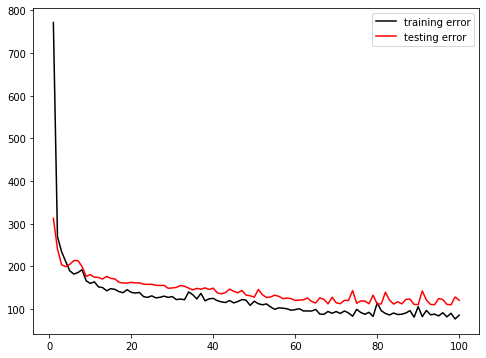

In [19]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.show()